# PyQNI demonstration notebook - Water quantification

## Introduction

This notebook demonstrates how to use PyQNI for quantifying water from neutron imaging experiments. Two different calculations are proposed.
- In the first one, an effective linear attenuation coefficient is computed based on the energy dependent attenuation coefficients and on the beam and detector characteristics. Then, the thickness is computed using Lambert-Beer law.
- In the second one, the relation between water thickness and transmission is calculated taking into account beam hardening effects, and is used for the quantification.

A predefined "water" material from the PyQNI framework is used in this case. For seeing how to define other hydrogen containing materials, see the notebook "PyQNI_demo_hydrogen_materials".

## Imports

First, we import the PyQNI framework. If the notebook is placed in te different location, the PyQNI framework path has to be updated.

In [1]:
import sys
sys.path.append(r'C:\Software\pyqni\framework') # update path if necessary
from PyQNI import beam, detector

We will also use the *matplotlib* package to display charts and the *numpy* package to work with arrays.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Water cross sections

Water is predefined in the PyQNI framework, so we just need to import the 'water' object.

In [3]:
from PyQNI_materials import water

For information, we plot here the energy dependent cross section (per molecule) and linear attenuation coefficients of water.

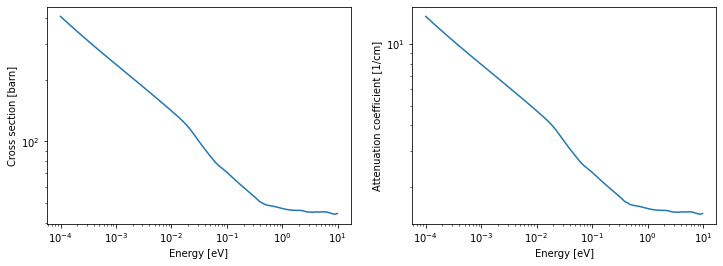

In [4]:
e, xs = water.cross_sections()
e, ac = water.att_coeff()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.loglog(e, xs)
plt.xlabel('Energy [eV]')
plt.ylabel('Cross section [barn]')

plt.subplot(1, 2, 2)
plt.loglog(e, ac)
plt.xlabel('Energy [eV]')
plt.ylabel('Attenuation coefficient [1/cm]')

plt.show()

## Effective water cross section

The effective water cross section for a given experiment depends on the beam spectrum and on the detector capture efficiency. For thicknesses of water where beam hardening effects (see below) can be neglected, the effective cross section $\sigma_{eff}$ is defined as:
\begin{equation}
\sigma_{eff} = \frac{\int_{0}^{\infty}  \Phi(E) \cdot c(E) \cdot \sigma(E) \cdot dE}{\int_{0}^{\infty}  \Phi(E) \cdot c(E) \cdot dE}
\end{equation}
Where $\Phi(E)$ is the beam intensity, $c(E)$ is the detector capture efficiency and $\sigma(E)$ is the energy resolved cross section.
To compute this effective cross section, we need to create objects representing the beam and the detector.

### Creation of beam and detector objects

The beam spectrum can be loaded by creating a *beam* object with the desired beamline as parameter (here, the NEUTRA beam line of SINQ at the Paul Scherrer Institute is used):

In [5]:
neutra = beam('NEUTRA')

As discussed above, computation of the effective cross section also required to know the energy dependent detector capture efficiency. this is done by creating a detector object. To do so, we first import the scintillator material. The *'gadox_sc'* predefined scintillator material is based on $Gd_2O_2S$ with a specific weight of 7.2 and assuming a porosity of 0.4.

In [6]:
from PyQNI_scintillators import gadox_sc

From this material, we create a detector having a 40 micrometer thick Gadox screen (units are in [cm])

In [7]:
gadox40 = detector(gadox_sc, thickness=0.004)

For information, the spectrum and capture efficiency as a function of energy are plotted here:

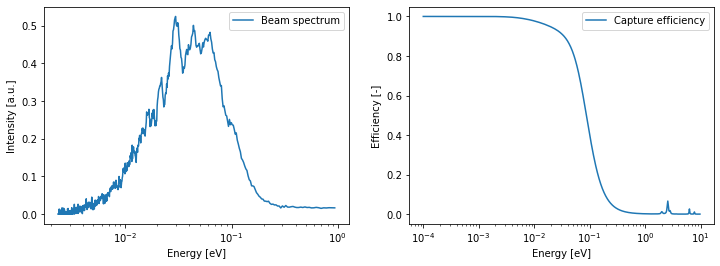

In [8]:
xs,_,ys = neutra.spectrum(gadox40)
xe,ye = gadox40.capt_eff()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.semilogx(xs,ys)
plt.legend(['Beam spectrum'])
plt.xlabel('Energy [eV]')
plt.ylabel('Intensity [a.u.]')

plt.subplot(1, 2, 2)
plt.semilogx(xe,ye)
plt.legend(['Capture efficiency'])
plt.xlabel('Energy [eV]')
plt.ylabel('Efficiency [-]')

plt.show()

### computing the effective cross section and attenuation coefficients

Once the beam and detector objects have been created, the calculation of the effective water cross section is simply obtained using the 'eff_cross_section' method (which uses the calcuation described previously):

In [9]:
water_xs_eff = water.eff_cross_section(neutra, gadox40)
print('The computed effective water cross section is {:.4g} barns'.format(water_xs_eff))

The computed effective water cross section is 102.6 barns


This gives us the cross section in [barns] per molecule of water. To obtain the attenuation coefficient in [1/cm], this cross section is usually multiplied by the molecular density. This is done automatically (using the atomic masses and the specific weight of the compound) when calling the 'eff_att_coeff' method:

In [10]:
water_ac_eff = water.eff_att_coeff(neutra, gadox40)
print('The computed effective water attenuation coefficient is {:.4g} cm^-1'.format(water_ac_eff))

The computed effective water attenuation coefficient is 3.432 cm^-1


### Simple conversion to water thickness using Lambert-Beer law

The relation between the water thickness $\delta$ and the transmission $\frac{I}{I_0}$ is given by the Lambert-Beer law:
\begin{equation}
\frac{I}{I_0}=e^{-\Sigma_{eff} \cdot \delta}
\end{equation}
Where $\Sigma_{eff}$ is the effective attenuation coefficient.
Here, we show the example for a series of water thicknesses ranging from 0 to 1 cm (with a linear scale on the left and a logarithmic scale on the right).

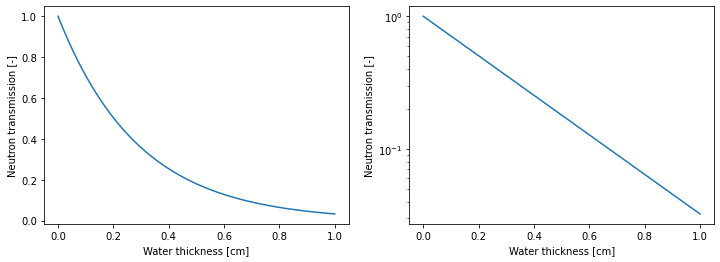

In [11]:
water_thickness = np.linspace(0,1,101)
neutron_transmission = np.exp(-water_ac_eff*water_thickness)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(water_thickness, neutron_transmission)
plt.xlabel('Water thickness [cm]')
plt.ylabel('Neutron transmission [-]')

plt.subplot(1, 2, 2)
plt.semilogy(water_thickness, neutron_transmission)
plt.xlabel('Water thickness [cm]')
plt.ylabel('Neutron transmission [-]')

plt.show()

### Example with a water filled cylindrical channel

We can apply this relation to compute the water thickness from a neutron transmission image. The used image "water_channel.fits" is a real measurement at the NEUTRA beamline and with a 40um thick Gadox scintillator. The object is a circular channel having a diameter of 12 mm, with the central part occupied by a rod having a diameter of 3 mm. The neutron transmission image includes all necessary corrections (alignment, intensity fluctuation, background) and is obtained by dividing the image of the channel full of water by the image of the dry channel. 

In [12]:
water_channel_fname = 'C:\Software\pyqni\demo\images\water_channel.fits' # update path if necessary

We open and display the transmission image (requires the 'astropy' package)

In [13]:
from astropy.io import fits
water_channel_trans_img = fits.open(water_channel_fname)[0].data

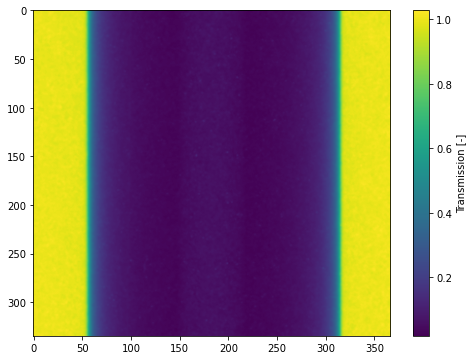

In [14]:
plt.figure(figsize=(8,6))
plt.imshow(water_channel_trans_img)
plt.colorbar().set_label('Transmission [-]')
plt.show()

We extract a horizontal profile of the neutron tansmission and we plot it (with linear scale on the left and logarithmic scale on the right):

In [15]:
trans_prof = np.mean(water_channel_trans_img, axis=0)

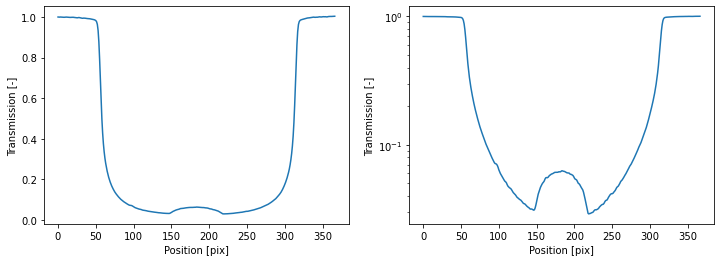

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(trans_prof)
plt.xlabel('Position [pix]')
plt.ylabel('Transmission [-]')

plt.subplot(1, 2, 2)
plt.semilogy(trans_prof)
plt.xlabel('Position [pix]')
plt.ylabel('Transmission [-]')

plt.show()

Note that the transmission is approaching zero in the center, which makes this case very challenging for quantification.

We compute the thickness profile based on the inversion of the Lambert-Beer law:
\begin{equation}
\delta = -\frac{ln(\frac{I}{I_0})}{\Sigma_{eff}}
\end{equation}

In [17]:
thick_prof = -np.log(trans_prof)/water_ac_eff

And we compute the real thickness profile based on the known object geometry

In [18]:
thick_real = 2*(np.maximum(0.6**2-((np.arange(367)-185)*0.004615)**2,0))**0.5 - 2*(np.maximum(0.15**2-((np.arange(367)-182)*0.004615)**2,0))**0.5

We compare the two profiles. Note that the water thickness is significantly underestimated.

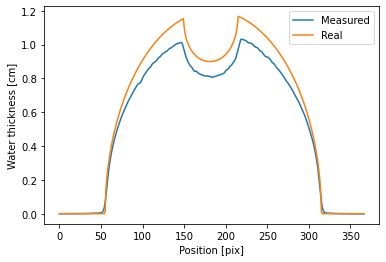

In [19]:
plt.plot(thick_prof)
plt.plot(thick_real)
plt.xlabel('Position [pix]')
plt.ylabel('Water thickness [cm]')
plt.legend(['Measured','Real'])
plt.show()

The main reason for this discrepancy is that we assumed that the relation between the transmission and the thickness followed the Lambert-Beer law. This is true for small thicknesses or for monochromatic beams, but for beams with a wide energy distribution and a large water thickness, beam hardening effects induce an important deviation.

## Conversion taking into account beam hardening

Beam hardening occurs when the energy dependent attenuation of neutron through thick samples results in a modification of the beam spectrum towards higher energies (because the lower energy neutrons are attenuated more strongly). This results in a change of the effective attenuation coefficient as a function of the thickness. In other words, the optical density $-ln(\frac{I}{I_0})$ is no more a linear function of the thickness.

A conventional way to take into account beam hardening is to use a polynomial function in the relation between $-ln(\frac{I}{I_0})$ and $\delta$, which is either obtained by calibration experiment or theoretically. In PyQNI, we compute the transmission at a few selected thicknesses and interpolate for thickness values between them. The transmission for a given thickness is obtained by using the Lambert-Beer law for each individual neutron energy (which is exact, as monochromatic beams do not suffer from beam hardening per definition). The transmission is obtained by integrating the intensity as a function of energy before and after the attenuation by the sample. The corresponding equation is as follows:
\begin{equation}
\frac{I}{I_0} = \frac{\int_{0}^{\infty}  \Phi(E) \cdot c(E) \cdot e^{-\Sigma(E) \cdot \delta} \cdot dE}{\int_{0}^{\infty} \Phi(E) \cdot c(E) \cdot dE}
\end{equation}
Note that the detector efficiency is also included in the calculation (similarly to the effective cross section calculation), because only the neutrons which are detected are to be taken into account.

### Forward conversion

The calculation above is included in the 'get_converter' method. Per default, this method computed the optical density $-ln(\frac{I}{I_0})$ for 10 different thicknesses ranging from $-\lambda$ to $9 \lambda$, where $\lambda$ is the mean free path of the neutrons in the considered material. the interpolation between these values is done using cubic splines. The 'get_converter' method returns a function which can be applied to single values, but also to profiles or to images.

Here, we get a forward converter function (thickness -> transmission). The beam and detector have to be specified. 'trans' also has to be specified as a result because the default is to return a converter with the optical density as a result.

In [20]:
conv_fwd = water.get_converter(neutra, gadox40, result='trans')

We plot the relations between thickness and transmission obtained using this converter function and compare them to the Lambert-Beer relation

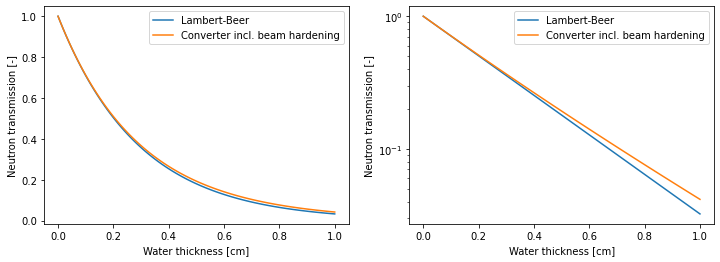

In [21]:
water_thickness = np.linspace(0,1,101)
neutron_transmission = np.exp(-water_ac_eff*water_thickness)
neutron_transmission_bh = conv_fwd(water_thickness)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(water_thickness, neutron_transmission)
plt.plot(water_thickness, neutron_transmission_bh)
plt.xlabel('Water thickness [cm]')
plt.ylabel('Neutron transmission [-]')
plt.legend(['Lambert-Beer', 'Converter incl. beam hardening'])

plt.subplot(1, 2, 2)
plt.semilogy(water_thickness, neutron_transmission)
plt.plot(water_thickness, neutron_transmission_bh)
plt.xlabel('Water thickness [cm]')
plt.ylabel('Neutron transmission [-]')
plt.legend(['Lambert-Beer', 'Converter incl. beam hardening'])

plt.show()

As can be noted the two results differ. The difference seems low on the linear scale, but as seen on the logarithmic scale it can induce significant errors when the transmission is very low.

### Backward conversion

The previous example did show how to compute the transmission when knowing the thickness. To quantify a thickness from a neutron transmission image, the conversion in the opposite direction is needed. The corresponsing converter is also obtained by the 'get_converter' method, but specifying the backward direction (transmission -> thickness)

In [22]:
conv_back = water.get_converter(neutra, gadox40, result='trans', cdir='backward')

We can then convert our measured transmission profile to a water thickness profile:

In [23]:
thick_prof_bh = conv_back(trans_prof)

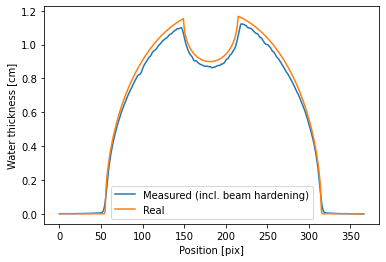

In [24]:
plt.plot(thick_prof_bh)
plt.plot(thick_real)
plt.xlabel('Position [pix]')
plt.ylabel('Water thickness [cm]')
plt.legend(['Measured (incl. beam hardening)','Real'])
plt.show()

As can be seen, the quantification is significantly improved by taking into account the beam hardening, though a residual error (about 5%) remains

### Pixel-wise conversion of images

The obtained converter can also be used on images to perform a pixel-wise conversion of the measured transmission to pixel values:

In [25]:
thick_img = conv_back(water_channel_trans_img)

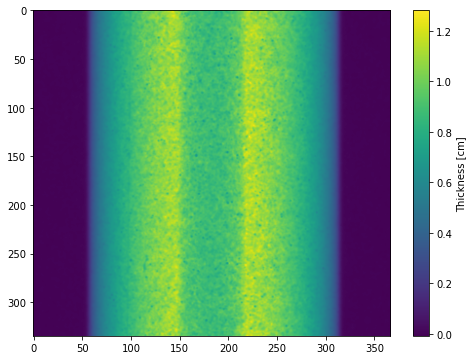

In [26]:
plt.figure(figsize=(8,6))
plt.imshow(thick_img)
plt.colorbar().set_label('Thickness [cm]')
plt.show()